# Обработка метаданных для снижения нагрузки

В отдельный ноутбук вынесена обработка файла meta_Grocery_and_Gourmet_Food.json.

Сделано это для того, чтобы снизить нагрузку на выделенные ресурсы в Kaggle и избежать ошибки переполнения памяти.

# Библиотеки и функции

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import json
import re
from datetime import datetime, date, time


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud, STOPWORDS 
import string
import re
import nltk
from nltk.util import ngrams
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from textblob import TextBlob

import itertools
# import ast
from itertools import combinations
from scipy.stats import ttest_ind, pearsonr

In [12]:
# Полезные функции

# Определение выбросов
def get_outlier(df, col):
    Q3 = pd.DataFrame.quantile(df, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')[col]
    Q1 = pd.DataFrame.quantile(df, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')[col]
    IQR = round(Q3-Q1,1)
    return df[~df[col].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)][col], Q1 - 1.5*IQR, Q3 + 1.5*IQR

# Информация о выбросах с графиками
def show_info(df, col, show=True):
    # Выводим количество выбросов и их границы
    out, lim1, lim2 = get_outlier(df, col)
    minCol = df[col].min()
    maxCol = df[col].max()
    median = df[col].median()
    nulCol = sum(pd.isnull(df[col]))
    
    cnt = min(int(df[col].value_counts().count()),2000)
    
    if show:
        print('Не заполнено: ', nulCol)
        print('Минимум: ', minCol)
        print('Максимум: ', maxCol)
        print('Медиана: ', median)
        print('Количество выбросов: ', len(out))
        if len(out) > 0:
            print('Нижняя граница выбросов: ', lim1)
            print('Верхняя граница выбросов: ', lim2)

        # Выводим графики: гистограмму и боксплот
        fig, axes = plt.subplots(1,2,figsize=(12,4))
        axes[0].hist(df[col], bins=cnt)
        axes[1].boxplot(df[col])
    
    return {'med': median, 'lm1': lim1, 'lm2': lim2}




# Сравнение двух графиков 
def val_log_plot(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].hist(df[col], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(col)

    ax[1].hist(np.log(df[col]+1), rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of '+col)

    plt.show()

# График с боксплотами
def show_boxplot(df, x_col, y_col):
    plt.figure(figsize=(12, 8))
    g = sns.boxplot(y=y_col, x=x_col, data=df, color='yellow')
    g.set_title(y_col + ' of ' + x_col, fontsize=20)
    g.set_ylabel(y_col, fontsize=15)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    plt.show()


# Преобразование в None для строковых признаков
def set_None(value):
    if value is None:
        return value
    else:        
        str_value = str(value).strip()
        if str_value == '' or str_value.lower() == 'nan':
            return None
        else:
            return str_value


# перевод в нижний регистр
def set_lower(value):
    if value is None:
        return value
    else:
        return value.lower()
    

# Получение самых популярных элементов списков
def get_top_bottom(column, percent):
    lst_temp = list(column.value_counts())
    tmp_sum = 0
    all_sum = sum(lst_temp)
    top_index = 0

    for cnt in lst_temp:
        tmp_sum += cnt
        if tmp_sum >= all_sum * percent/100:
            top_index = lst_temp.index(cnt)
            break;

    all_val = column.value_counts().index
    top_val = list(all_val)[:top_index]
    bottom_val = list(set(all_val) - set(top_val))

    return top_val, bottom_val

# Чтение данных

In [2]:
# Читаем данные
with open('meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))
        
meta = pd.DataFrame(meta_list)

# Удаляем фичи с большим количеством пропусков,
meta = meta.drop(['similar_item', 'tech1', 'fit', 'date'], axis=1)

# Удаляем непригодные к использованию фичи и фичи, собранные из других столбцов
meta = meta.drop(['details', 'image'], axis=1)

# Анализ и подготовка данных

In [3]:
# Для более подробного анализа превратим фичи в виде списков в строки
metastr = meta.copy()
metastr['category'] = metastr['category'].astype('str')
metastr['also_view'] = metastr['also_view'].astype('str')
metastr['also_buy'] = metastr['also_buy'].astype('str')
metastr['feature'] = metastr['feature'].astype('str')
metastr['rank'] = metastr['rank'].astype('str')

In [4]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   category     287209 non-null  object
 1   description  251802 non-null  object
 2   title        287205 non-null  object
 3   brand        275787 non-null  object
 4   rank         275494 non-null  object
 5   also_view    121012 non-null  object
 6   main_cat     285716 non-null  object
 7   price        132136 non-null  object
 8   asin         287209 non-null  object
 9   also_buy     83332 non-null   object
 10  feature      16374 non-null   object
dtypes: object(11)
memory usage: 24.1+ MB


## category

In [7]:
meta[['category']].info()
print('')
print('Уникальных значений: ', len(metastr.category.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  287209 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB

Уникальных значений:  1356


Пропусков нет. В столбце находятся списки категорий товара.

In [8]:
meta.iloc[0]['category']

['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']

In [9]:
# Создадим фичу с длиной списка категорий
meta['category_len'] = meta['category'].apply(lambda x: len(x))

In [10]:
meta['category_len'].value_counts()

4     126767
3      79210
5      67782
2      11002
6       2396
8         19
9         15
7          8
10         7
11         2
13         1
Name: category_len, dtype: int64

Не заполнено:  0
Минимум:  2
Максимум:  13
Медиана:  4.0
Количество выбросов:  2448
Нижняя граница выбросов:  1.5
Верхняя граница выбросов:  5.5


{'med': 4.0, 'lm1': 1.5, 'lm2': 5.5}

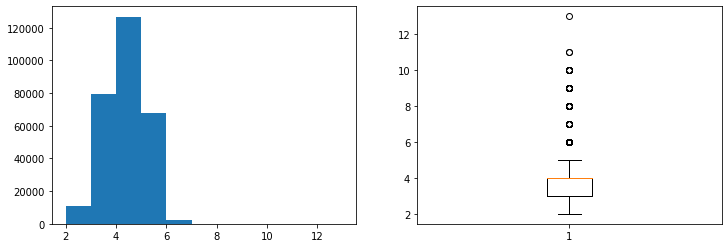

In [13]:
show_info(meta, 'category_len')

In [14]:
# Добавим столбец с выбросами количества категорий
meta['category_len_out'] = meta['category_len'].apply(lambda x: 1 if x > 2 and x < 6  else 0)

In [15]:
mtr = meta.category.explode().value_counts()
mtr[0:20]

Grocery & Gourmet Food                    287209
Beverages                                  61747
Cooking & Baking                           46153
Coffee, Tea & Cocoa                        45203
Candy & Chocolate                          40694
Snack Foods                                32282
Tea                                        23516
Herbs, Spices & Seasonings                 19226
Coffee                                     18669
Bottled Beverages, Water & Drink Mixes     15401
Sauces, Gravies & Marinades                11019
Frosting, Icing & Decorations              10752
Canned, Jarred & Packaged Foods            10078
Food & Beverage Gifts                       9665
Cookies                                     8574
Jelly Beans & Gummy Candy                   8337
Cake & Cupcake Toppers                      8325
Breakfast Foods                             7728
Tea Samplers                                7612
Mixed Spices & Seasonings                   7606
Name: category, dtyp

In [16]:
# Создадим dummy-переменные
N = 20
top_val = mtr.index[0:N]
bottom_val = mtr.index[N:]
i = 1
for val in top_val:
    meta['cat'+str(i)] = meta['category'].apply(lambda x: 1 if val in x else 0)
    i += 1
    
meta['cat_other'] = meta['category'].apply(lambda x: 1 if len(set(x) & set(bottom_val)) > 0 else 0)

In [17]:
# Проверим на примере
print(meta.iloc[9834].category)
meta.iloc[9834]

['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Cheddar']


category            [Grocery & Gourmet Food, Dairy, Cheese & Eggs,...
description         [White Cheddar has long been a favorite on the...
title               Country White Cheddar Cheese from Wisconsin Ch...
brand                                         The Wisconsin Cheeseman
rank                                      67,318inGroceryGourmetFood(
also_view           [B009Y7I2F0, B00N07R6F2, B005ZFTLZU, B005ZFU6O...
main_cat                                                      Grocery
price                                                          $29.99
asin                                                       B000BPG88C
also_buy                                                          NaN
feature                                                           NaN
category_len                                                        4
category_len_out                                                    1
cat1                                                                1
cat2                

## description

In [19]:
meta[['description']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  251802 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB


In [20]:
# Глянем на данные
meta.description[23343]

["USDA Prime Fresh American Lamb Chops. Avg cut 1.1/4'' inch weight is 6 oz per chop. Ideal for broiling or Grilling.Always fresh, never frozen. All our USDA Prime meat is custom cut to order, and vacuum packed. We chill the meat to preserve the freshness for shipping only.",
 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.']

Проведем анализ текста. Можно было бы в качестве новой фичи взять длину описания, но делать это не будем, потому что она вряд ли влияет на оценку.

In [21]:
# Заменим пропуски пустой строкой
meta['description'] = meta['description'].apply(set_None)
meta['description'] = meta['description'].apply(set_lower)
meta['description'] = meta['description'].apply(lambda x: '' if x is None else x)

In [22]:
# Заменим перевод строки '\n' и знаки препинания на ' '
intab = ".,;:!?-'()" 
outtab = "          " 
trantab = str.maketrans(intab, outtab)

meta['description'] = meta['description'].apply(lambda x: x.replace('\n', ' '))
meta['description'] = meta['description'].apply(lambda x: x.translate(trantab))

In [23]:
# Проведем анализ текста TF-IDF и снизим размерность
stopwords=nltk.corpus.stopwords.words()
description = meta['description'].copy(deep=True)

tf_idf = TfidfVectorizer(max_features=50, stop_words=stopwords)
tf_idf_feature = tf_idf.fit_transform(description).toarray()

pca = PCA(n_components=2, random_state=0)
tf_idf_pc = pca.fit_transform(tf_idf_feature)
df_tfidf = pd.DataFrame(tf_idf_pc, columns=['desc_tfidf1', 'desc_tfidf2'])

meta = pd.concat([meta, df_tfidf], axis=1)

In [24]:
meta.iloc[23343]

category               [Grocery & Gourmet Food, Meat & Seafood, Lamb]
description         ["usda prime fresh american lamb chops  avg cu...
title               USDA Prime Fresh American Lamb Rib Chops Frenc...
brand                                                     PastaCheese
rank                                     394,794inGroceryGourmetFood(
also_view           [B06WWH9Q34, B001DTMLRM, B000Q19PEK, B00TQ6OC7...
main_cat                                                      Grocery
price                                                          $69.99
asin                                                       B000Q19PEA
also_buy                                                 [B007OC3734]
feature                                                           NaN
category_len                                                        3
category_len_out                                                    1
cat1                                                                1
cat2                

## brand

In [31]:
meta[['brand']].info()
print('')
print('Уникальных значений: ', len(metastr.brand.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   brand   275787 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB

Уникальных значений:  38915


In [32]:
meta['brand'].value_counts()[:20]

Unknown                           1782
Black Tie Mercantile              1458
Trader Joe's                      1234
McCormick                         1041
The Nutty Fruit House              998
Starbucks                          924
Jelly Belly                        902
Nestle                             779
Frontier                           771
Green Mountain Coffee Roasters     734
Bob's Red Mill                     716
DecoPac                            713
HERSHEY'S                          712
Roland                             690
Wholespice                         656
Cadbury                            634
Quaker                             616
Lindt                              596
Kraft                              595
Ghirardelli                        594
Name: brand, dtype: int64

Есть пропуски, но их не слишком много. Заменим их строкой 'Unknown'.   
Снова выделим N самых популярных брендов и превратим в dummy-переменные.   

In [33]:
meta.brand = meta.brand.fillna('Unknown')

In [34]:
mtr = meta['brand'].value_counts()
N = 15

In [35]:
# Создадим dummy-переменные
top_val = mtr.index[0:N]
bottom_val = mtr.index[N:]
i = 1
for val in top_val:
    meta['brand'+str(i)] = meta['brand'].apply(lambda x: 1 if val == x else 0)
    i += 1
    
meta['brand_other'] = meta['brand'].apply(lambda x: 1 if x in bottom_val else 0)

In [36]:
meta.iloc[40892]

category            [Grocery & Gourmet Food, Food & Beverage Gifts...
description         [ it+s simply the perfect gift for friends and...
title               Katie Reilly's Irish Soda Bread Mix Gift Bag, ...
brand                                                  Katie Reilly's
rank                                     710,773inGroceryGourmetFood(
also_view                                                         NaN
main_cat                                                      Grocery
price                                                             NaN
asin                                                       B001EPPJRE
also_buy                                                          NaN
feature                                                           NaN
category_len                                                        3
category_len_out                                                    1
cat1                                                                1
cat2                

## title

In [37]:
meta[['title']].info()
print('')
print('Уникальных значений: ', len(metastr.title.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   287205 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB

Уникальных значений:  281642


In [38]:
# Есть пропуски, заполним их
meta.title = meta.title.apply(set_None)
meta.title = meta.apply(lambda row: row['title'] if not (row['title'] is None) \
                        else 'Unknown item brand of '+row['brand'] if not row['brand'] is None \
                        else 'Unknown item', axis=1)

In [40]:
# Встречаются "мусорные" названия, в которые затесался js-код. Подчистим их
meta.iloc[31885].title

'var aPageStart = (new Date()).getTime();\nvar ue_t0=ue_t0||+new Date();\n\nwindow.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;\nif (window.ue_ihb === 1) {\n\nvar ue_csm = window,\n    ue_hob = +new Date();\n(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function(b){for(var a;a=c.shift();)b(a[0],a[1],a[2])};b[a].isStub=1}};e.exec=function(b,a){return function(){if(1==window.ueinit)try{return b.apply(this,arguments)}catch(c){ueLogError(c,{attribution:a||"undefined",logLevel:"WARN"})}}}})(ue_csm);\n\n\n    var ue_err_chan = \'jserr-rw\';\n(function(d,e){function h(f,b){if(!(a.ec>a.mxe)&&f){a.ter.push(f);b=b||{};var c=f.logLevel||b.logLevel;c&&c!==k&&c!==m&&c!==n&&c!==p||a.ec++;c&&c!=k||a.ecf++;b.pageURL=""+(e.location?e.location.href:"");b.logLevel=c;b.attribution=f.attribution||b.attribution;a.erl.

In [41]:
# Подчистим плохие названия товара
# Название можно вытащить и из js-кода, который подсунут вместо названия,
# и частично из описания, например так:  description[:50],
# но обойдемся примитивным решением
meta.title = meta.apply(lambda row: row['title'] if not ('var aP' in row['title']) \
                        else 'Unknown item brand of '+row['brand'] if not row['brand'] is None \
                        else 'Unknown item', axis=1)
print(meta.iloc[31885].title)

Unknown item brand of Biofair


In [42]:
print(meta.title[67])
print(meta.description[67])

Wilton Jimmies Rainbow Sprinkle Assortment, 3.2 oz. - Cake Decorating Supplies
[ sprinkle your treats with sweet color using this assortment of jimmies in blue  red  green  yellow  orange  and pink  these rainbow sprinkles are great for cupcakes  cakes and other desserts  ]


Информация в title пересекается с description. Title удалять не будем, он нам пригодится для вывода предсказанных товаров. Удалить можно description.

## rank

In [44]:
meta[['rank']].info()
print('')
print('Уникальных значений: ', len(metastr['rank'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   rank    275494 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB

Уникальных значений:  246967


In [45]:
metastr['rank'].value_counts()

nan                               11715
17,849inGroceryGourmetFood(          14
41,792inGroceryGourmetFood(           8
289,988inGroceryGourmetFood(          5
50,411inGroceryGourmetFood(           5
                                  ...  
185,263inGroceryGourmetFood(          1
540,391inGroceryGourmetFood(          1
234,310inGroceryGourmetFood(          1
1,371,081inGroceryGourmetFood(        1
799,433inGroceryGourmetFood(          1
Name: rank, Length: 246967, dtype: int64

Видно, что поле устроено так: рейтинг в сети + название сети.    
Пропусков около 5%. Будем считать, что у пропущенных значений ранг = 9999999.   
Среди данных есть и затесавшийся мусор нестрокового типа. Почистим.

Приведем значения данного признака к единому числовому виду

In [46]:
# Приведем к строкам
meta['rank'] = meta['rank'].astype('str')
meta['rank'] = meta['rank'].apply(set_None)

In [47]:
# Заполним пропуски
meta['rank'] = meta['rank'].fillna('9999999inNoname')

In [48]:
# Разделим оценку и категорию товара
meta['rank0'] = meta['rank'].apply(lambda x: x.split('in')[0])
meta['rank1'] = meta['rank'].apply(lambda x: x.split('in')[1])

In [49]:
# Нормализуем категорию товара
stores = ['Grocery', 'Health', 'Office', 'Sports', 'Kitchen', 'Patio', 'Beauty', 'GiftCards',
          'Automotive', 'Appliances', 'MoviesTV', 'Baby', 'AmazonLaunchpad', 'Video Games',
          'Tools', 'Industrial', 'Toys', 'Pet', 'Electronics', 'Camera', 'Musical', 'Arts', 'Software']

for st in stores:
    meta['rank1'] = meta['rank1'].apply(lambda x: st if st in x else x)
    
# Проверяем
print(meta['rank1'].unique())

['Grocery' 'Kitchen' 'Health' 'Patio' 'Noname' 'Toys' 'Beauty' 'Sports'
 'Arts' 'Electronics' 'Pet' 'Industrial' 'CDsV' 'Tools' 'Office'
 'MoviesTV' 'Automotive' 'Software' 'Cloth' 'Camera' 'Musical' 'Baby'
 'Video Games' 'AmazonLaunchpad' 'Appliances' 'GiftCards']


In [50]:
# Нормализуем рейтинг товара
meta['rank0'] = meta['rank0'].apply(lambda x: re.sub('\D', '', x)).astype('float').astype('int32')

In [51]:
meantr = meta[meta['rank0'] < 9999999]['rank0'].mean()
meta['rank0'] = meta['rank0'].apply(lambda x: x if x < 9999999 else meantr)

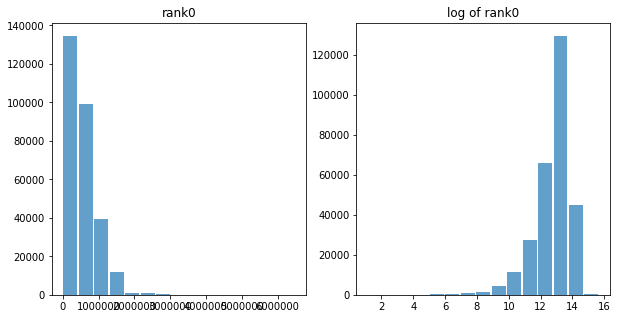

In [52]:
# Проверим распределение
val_log_plot(meta, 'rank0')

Логарифмирование приводит к почти нормальному виду.   
Было предположение, что ранг рассчитывался отдельно по каждой категории и что стоит нормализовать его отдельно по категориям. Но пример ниже показывает, что данных не хвататет. Например, в категории 'Pet' уникальных товаров 128, а рейтинги у них более 100 тысяч. То есть либо рейтинг по категорям, но мы имеем не все товары в категории - либо рейтинг сквозной по всем товарам. С первым вариантом ничего не поделать. Поэтому предположим второй вариант.

In [53]:
display(meta[meta.rank1=='Pet'].rank0)

2976       140227.0
2992       711344.0
3126      1270722.0
3193       122031.0
3194      1372236.0
            ...    
274121     223949.0
274630     270190.0
279261      41117.0
279975     361597.0
283354     581259.0
Name: rank0, Length: 128, dtype: float64

In [54]:
# Прологарифмируем рейтинг
meta['rank0'] = np.log(meta['rank0'])

## also_view

In [55]:
meta[['also_view']].info()
print('')
print('Уникальных значений: ', len(metastr['also_view'].unique()))
display(metastr['also_view'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   also_view  121012 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB

Уникальных значений:  114541


nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   166197
['B07FP2GBMC', 'B015AN72FM', 'B004B7C524', 'B00H5INMZU', 'B00MQXYWOE', 'B005D8T86G', 'B008XJAP8C', 'B008OGCH80', 'B00VCCPAEQ', 'B0001M10TM', 'B00IQXHEOI', 'B01F9LPP4U', 'B000N8GUC6', 'B00BEQO67M', 'B071KH1X16', 'B01LY39

In [56]:
print(meta.also_view[892])

['B00NUS00Z4', 'B00NZEO5R2', 'B0087EO21Y', 'B01AJ5GT7S', 'B01N014KFH', 'B001NG72UQ', 'B0000DYNFF', 'B001NGAT60', 'B001SAWMHA', 'B001NG72RY', 'B001VNKZQY', 'B008XDJ1C4', 'B07JJYVV39', 'B06W2G86T1', 'B00CL9QRQY', 'B076JNKD6W', 'B019LQISSY', 'B07H5VHSDQ', 'B00IEVYOW2', 'B075Y6TMMM', 'B07H64W18P', 'B008BTHDQQ', 'B00OYW1T8C', 'B001NG7242', 'B00UQOF6F4', 'B000KEPBBY', 'B00NUOTOY6', 'B003SLQG5G', 'B001NG72EC', 'B0087EO47Q', 'B0087EO42G', 'B0000DYNFI', 'B00O09AM7I', 'B00NZD1878']


Признак показывает, какие товары просматривали вместе с данным товаром.    
Пропусков - половина. Будем считать, что если значений нет, то список просматриваемых пустой. То есть, с товаром ничего не просматривали.   
Приведем поле к списку и пропуски заполним пустыми списками.

In [57]:
# Заполним пропуски
meta['also_view'] = meta['also_view'].apply(set_None)
meta['also_view'] = meta['also_view'].apply(lambda x: [] if x is None else x)

In [58]:
meta.also_view.sample(5)

237219                                                   []
286553    ['B07DQQZQQ3', 'B00AFYP5T2', 'B07DV1T3JT', 'B0...
236270                                       ['B00TS6W8NE']
141316                         ['B00GT0VRES', 'B01LYVBTSA']
269538                                                   []
Name: also_view, dtype: object

Столбец будем использовать для вывода в сервисе. Для моделирования непонятно, нужен ли он. Попозже можно попробовать добавить длины списков как новую фичу.

## main_cat

In [59]:
meta[['main_cat']].info()
print('')
print('Уникальных значений: ', len(metastr['main_cat'].unique()))
display(metastr['main_cat'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   main_cat  285716 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB

Уникальных значений:  27


Grocery                         261994
Amazon Home                       8957
Health & Personal Care            8547
Toys & Games                      1935
All Beauty                        1604
Industrial & Scientific            981
Office Products                    610
Sports & Outdoors                  396
Cell Phones & Accessories          167
Pet Supplies                       133
Arts, Crafts & Sewing              132
Baby                                95
Tools & Home Improvement            66
Computers                           39
All Electronics                     20
Home Audio & Theater                15
Automotive                           7
Movies & TV                          4
Musical Instruments                  3
Camera & Photo                       3
Video Games                          2
Software                             2
Gift Cards                           1
Car Electronics                      1
Portable Audio & Accessories         1
Appliances               

Видно, что эта фича повторяет созданную только что фичу rank1. Поэтому rank1 можно удалить.

In [60]:
meta = meta.drop(['rank1'], axis=1)

In [61]:
# Избавимся от пропусков
meta.main_cat = meta.main_cat.fillna('Noname')

Столбец будет полезен не при моделировании, а для выдачи информации о рекомендованном товаре.

## price

In [62]:
meta[['price']].info()
print('')
print('Уникальных значений: ', len(metastr['price'].unique()))
display(metastr['price'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   price   132136 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB

Уникальных значений:  9338


$14.99              2076
$9.99               2029
$19.99              1580
$12.99              1498
$7.99               1209
                    ... 
$82.69                 1
$168.50                1
$59.07                 1
$135.72                1
$38.00 - $885.00       1
Name: price, Length: 9337, dtype: int64

Пропусков примерно половина. Для моделирования заменим пропуски средней ценой по каждой категории (main_cat).

In [63]:
# Чистим данные
meta['price'] = meta['price'].apply(set_None)
meta.price = meta.price.fillna('$0.00')
meta['price'] = meta['price'].apply(lambda x: re.sub('[^\d\.]', '', x))

meta['price'] = meta['price'].apply(lambda x: '0.00' if re.match("^\d+?\.\d+?$", x) is None else x).astype('float')

In [64]:
meta[meta['price']==0]

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,...,brand8,brand9,brand10,brand11,brand12,brand13,brand14,brand15,brand_other,rank0
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...",[ shipped from uk please allow 10 to 21 busin...,Trim Healthy Mama Xylitol,Unknown,"315,867inGroceryGourmetFood(",[],Grocery,0.0,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",...,0,0,0,0,0,0,0,0,0,12.663077
16,"[Grocery & Gourmet Food, Canned, Jarred & Pack...",[ kashmiri mirch is a special blend of medium ...,MDH Kashmiri Mirch 100g,MDH,"329,103inGroceryGourmetFood(",['B07BY73J3N'],Grocery,0.0,5478541265,NaN,...,0,0,0,0,0,0,0,0,1,12.704126
17,"[Grocery & Gourmet Food, Canned, Jarred & Pack...","[""whether you prefer them stuffed pitted or ...",Goya Stuffed Olive with Minced Tuna 5.25 ounce...,Goya,"626,163inGroceryGourmetFood(",[],Grocery,0.0,5643467860,[B004IMJL1U],...,0,0,0,0,0,0,0,0,1,13.347366
18,"[Grocery & Gourmet Food, Breads & Bakery, Cakes]","[""new birthday cake m&m s"" statements regard...",Mars New Birthday Cake M&M's 39.7G - American ...,Mars,"673,482inGroceryGourmetFood(",[],Grocery,0.0,6040343958,NaN,...,0,0,0,0,0,0,0,0,1,13.420217
19,"[Grocery & Gourmet Food, Frozen, Ice Cream & N...",[ make your very own ice cream treats at home ...,Chill Factor Ice Cream Maker (Choc Delight),Chill Factor,"1,636,575inHealthHousehold(",[],Health & Personal Care,0.0,6040763906,NaN,...,0,0,0,0,0,0,0,0,1,14.308116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287199,"[Grocery & Gourmet Food, Beverages, Bottled Be...",[ we get it most meal replacements and protei...,WakeShake Collagen Protein Meal Replacement Sh...,WakeShake,"269,860inGroceryGourmetFood(","['B072KFZ9TQ', 'B0759SL8Y6', 'B06W2K24CZ', 'B0...",Grocery,0.0,B01HJ7QPKU,"[B01LZ73FXY, B07229QF2F, B01H298206, 162860264...",...,0,0,0,0,0,0,0,0,1,12.505659
287200,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",[ features/specifications product style 24pcs...,Drhob 24 Pcs Icing Piping Nozzles Pastry Tips ...,Dhrob,">#603,338 in Grocery & Gourmet Food (See Top 1...",[],Amazon Home,0.0,B01HJ9Y7OO,NaN,...,0,0,0,0,0,0,0,0,1,13.310233
287202,"[Grocery & Gourmet Food, Cooking & Baking, Coo...",[ light golden color mild dry sherry flavor ...,Holland House Sherry Cooking Wine 16 fl.oz,Mizkan,"459,035inGroceryGourmetFood(",[],Grocery,0.0,B01HJEK5QS,NaN,...,0,0,0,0,0,0,0,0,1,13.036882
287203,"[Grocery & Gourmet Food, Condiments & Salad Dr...",[ a unique blend of herbs just goddess from h...,"HAMPTON CREEK Just Goddess Dressing, 12 Fluid ...",Hampton Creek,"492,676inGroceryGourmetFood(",[],Grocery,0.0,B01HJEO4QK,"[B01HJEHE9E, B01HJF6FRA, B01N6LF9LZ]",...,0,0,0,0,0,0,0,0,1,13.107607


In [65]:
# Пропуски заполняем средним значением по главной категории товара
match = dict(np.round(meta[meta['price']>0].groupby('main_cat')['price'].mean(),2))
match1 = dict(np.round(meta.groupby('main_cat')['price'].mean(),2))

match['Camera & Photo'] = 25.00
match['Cell Phones & Accessories'] = 15.00
match['Home Audio & Theater'] = 5.00
match['Musical Instruments'] = 30.00
match['Software'] = 20.00

meta['price'] = meta.apply(lambda row: match[row['main_cat']] if row['main_cat'] in match and row['price']==0 else row['price'], 
                           axis = 1)

In [66]:
meta['price'] = meta['price'].apply(lambda x: 5 if x==0 else x)

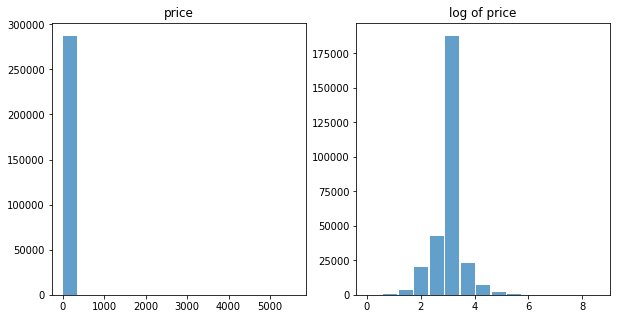

In [67]:
val_log_plot(meta,'price')

In [68]:
# Прологарифмируем цену, так как логарифмирование приводит распределение к нормальному
meta['price_log'] = np.log(meta['price'])

## also_buy

In [69]:
meta[['also_buy']].info()
print('')
print('Уникальных значений: ', len(metastr['also_buy'].unique()))
display(metastr['also_buy'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   also_buy  83332 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB

Уникальных значений:  80064


nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Признак показывает, какие товары покупали вместе с данным товаром.   
Пропусков - подавляющее большинство, но пропущенные значения легко истолковываются. Они означают, что с товаром ничего не покупали.   
Приведем поле к списку и пропуски заполним пустыми списками.

In [70]:
# Заполним пропуски
meta['also_buy'] = meta['also_buy'].apply(set_None)
meta['also_buy'] = meta['also_buy'].apply(lambda x: [] if x is None else x)

Данный столбец пригодится не для моделирования, а для рекомендации напрямую.

## feature

In [71]:
meta.feature[90]

['Includes a .25-ounce bottle of cake sparkles',
 'Instantly adds colorful accents to cakes, cupcakes and iced cookie',
 'No-mess, taste-free formula',
 'Comes in a variety of color options',
 'Comes in a variety of color options to fit all of your decorating style needs']

In [73]:
meta[['feature']].info()
print('')
print('Уникальных значений: ', len(metastr['feature'].unique()))
display(metastr['feature'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  16374 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB

Уникальных значений:  12153


nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   270835
['High quality edibles to decorate your cupcakes, cookies, baked goods and ice cream; Items within same container may vary slightly in shade', 'This product is prepared and packaged using machines that may come in contact with Wheat/Gluten, Eggs, Dairy Products, Pean

Подавляющее количество строк имеют значение nan для данной фичи. Удалим столбец.

In [76]:
meta = meta.drop(['feature'], axis=1)

# Сохранение обработанного результата

In [77]:
meta.shape

(287209, 53)

In [79]:
# Удалим дубли. Для этого приведем списочные фичи к строкам.
# Для более подробного анализа превратим фичи в виде списков в строки
meta['category'] = meta['category'].astype('str')
meta['also_view'] = meta['also_view'].astype('str')
meta['also_buy'] = meta['also_buy'].astype('str')
meta['rank'] = meta['rank'].astype('str')

In [80]:
meta = meta.drop_duplicates()
meta.shape

(283512, 53)

In [81]:
meta.to_csv('meta_prep.csv', index=False)